What is this notebook for?

I want to build a web service that:
- Gets the URL in the request
- Loads the image from this URL
- Uses TensorFlow Lite to apply the model to the image and get the predictions
- Responds with the results

Steps:
- Testing the model
- Converting the model to TensorFlow Lite format
- Loading the model and getting input and output indices
- Inference part
- Removing TensorFlow dependency
- Excluding TensorFlow dependency completely

- Create and test the lambda function

In [1]:
%autosave 0

Autosave disabled


## Step 0: Testing the model

In [7]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image
from io import BytesIO
from keras.preprocessing.image import load_img

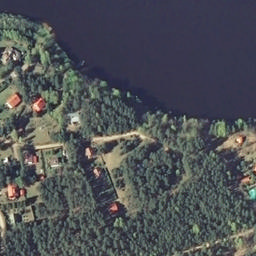

In [4]:
model = keras.models.load_model('./../Model/model_unet_noClassWeights_drop50_256_30_0.972.keras')

image_path = "./../Data50_res256_filtered_20/validate/sat/sat_N-33-60-D-d-1-2_02_02.tif"
#with open(image_path, 'rb') as file:
#    image_data = file.read()

img = load_img(image_path, target_size=(256,256))
img

In [10]:
# Function to load and preprocess a single example
def preprocess_example(img):
    #input_image = np.array(Image.open(img)) / 255.0
    input_image = np.array(img) / 255.0
    return np.expand_dims(input_image, axis=0)

def recolor_prediction(predicted_mask):
    # Define colors for each class
    class_colors = {
        0: (0, 0, 0),        # unlabeled
        1: (255, 0, 0),      # buildings
        2: (34, 139, 34),    # woodlands
        3: (0, 0, 255),      # water
        4: (184, 115, 51)    # road
    }

    # Convert ground truth image to numpy array
    pred_array = np.array(predicted_mask)

    # Apply color mapping
    pred_colored = np.zeros(pred_array.shape + (3,), dtype=np.uint8)
    for class_label, color in class_colors.items():
        pred_colored[pred_array == class_label] = np.array(color)
    
    return pred_colored

1/1 [==============================] - 0s 472ms/step


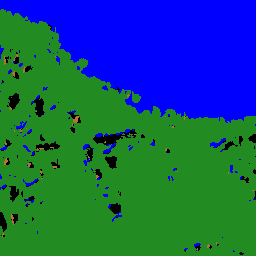

In [13]:
# Load and preprocess input image
input_image = preprocess_example(img)
    
# Predict with the model
predictions = model.predict(input_image)
predicted_mask = np.argmax(predictions[0], axis=-1)

colored_predicted_mask = recolor_prediction(predicted_mask)
        
PIL_image = Image.fromarray(colored_predicted_mask.astype('uint8'), 'RGB')
PIL_image

## Step 1: Converting the model to TensorFlow Lite format

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

# Saving the model in tflite format
with open('./../Model/final-model.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\husky\AppData\Local\Temp\tmp468_tvtt\assets


INFO:tensorflow:Assets written to: C:\Users\husky\AppData\Local\Temp\tmp468_tvtt\assets


## Step 2: Loading the model and getting input and output indices

In [15]:
import tensorflow.lite as tflite 

interpreter = tflite.Interpreter(model_path="./../Model/final-model.tflite")

# Loading weights from model to memory
interpreter.allocate_tensors()

In [16]:
# Figuring out the input index
interpreter.get_input_details()

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([  1, 256, 256,   3]),
  'shape_signature': array([ -1, 256, 256,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [19]:
input_index = interpreter.get_input_details()[0]['index']
input_index

0

In [20]:
# Figuring out the output index
output_index = interpreter.get_output_details()[0]['index']
output_index

97

## Step 3: Inference part

In [23]:
image_path = "./../Data50_res256_filtered_20/validate/sat/sat_N-33-60-D-d-1-2_02_02.tif"
img = load_img(image_path, target_size=(256,256))

x = np.array(img)
x = np.float32(x) / 255.
# Turning this image into a batch of one image
X = np.array([x])

In [24]:
# Initializing the input of the interpreter with the image X
interpreter.set_tensor(input_index, X)

# Invoking the computations in the neural network
interpreter.invoke()

In [25]:
# Results are in the output_index. so fetching the results...
preds = interpreter.get_tensor(output_index)
preds

array([[[[1.06299378e-01, 1.94523782e-02, 3.21318239e-01,
          5.28715253e-01, 2.42148433e-02],
         [5.64490296e-02, 6.62778504e-03, 2.17529714e-01,
          7.11821556e-01, 7.57189002e-03],
         [3.78399827e-02, 3.34672187e-03, 1.58173695e-01,
          7.96323299e-01, 4.31634160e-03],
         ...,
         [3.41630876e-02, 3.00576258e-03, 1.19808204e-01,
          8.39287817e-01, 3.73505894e-03],
         [5.76982088e-02, 5.97023824e-03, 2.06292018e-01,
          7.21793234e-01, 8.24628957e-03],
         [9.27067697e-02, 1.46192675e-02, 3.00565779e-01,
          5.73053479e-01, 1.90547127e-02]],

        [[7.58835897e-02, 5.65736787e-03, 2.36068383e-01,
          6.76109135e-01, 6.28154445e-03],
         [2.85485070e-02, 8.87711940e-04, 1.10390596e-01,
          8.59332681e-01, 8.40535329e-04],
         [1.84458364e-02, 4.61533520e-04, 8.92433524e-02,
          8.91333997e-01, 5.15292399e-04],
         ...,
         [1.84173901e-02, 5.32025471e-04, 5.26704267e-02,
   

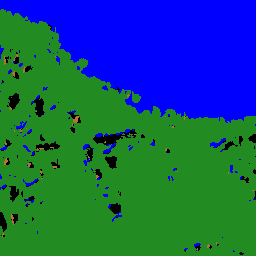

In [26]:
predicted_mask = np.argmax(preds[0], axis=-1)

colored_predicted_mask = recolor_prediction(predicted_mask)
        
PIL_image = Image.fromarray(colored_predicted_mask.astype('uint8'), 'RGB')
PIL_image

## Step 4: Removing TensorFlow dependency
I only want to use TensorFlow Lite, so I need to exclude the dependency while using the function load_image which lives in Keras, because Keras is not available in TensorFlow Lite.

In [27]:
# Reading the image
image_path = "./../Data50_res256_filtered_20/validate/sat/sat_N-33-60-D-d-1-2_02_02.tif"
img = load_img(image_path, target_size=(256,256))

# Preprocessing the image
x = np.array(img)
x = np.float32(x) / 255.
# Turning this image into a batch of one image
X = np.array([x])

Let's see how to get rid of this dependency...

In [28]:
def recolor_prediction(predicted_mask):
    # Define colors for each class
    class_colors = {
        0: (0, 0, 0),        # unlabeled
        1: (255, 0, 0),      # buildings
        2: (34, 139, 34),    # woodlands
        3: (0, 0, 255),      # water
        4: (184, 115, 51)    # road
    }

    # Convert ground truth image to numpy array
    pred_array = np.array(predicted_mask)

    # Apply color mapping
    pred_colored = np.zeros(pred_array.shape + (3,), dtype=np.uint8)
    for class_label, color in class_colors.items():
        pred_colored[pred_array == class_label] = np.array(color)
    
    return pred_colored

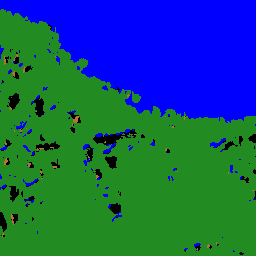

In [29]:
# Initializing the input of the interpreter with the image X
interpreter.set_tensor(input_index, X)

# Invoking the computations in the neural network
interpreter.invoke()

# Results are in the output_index. so fetching the results...
predicted_mask = np.argmax(preds[0], axis=-1)

colored_predicted_mask = recolor_prediction(predicted_mask)
        
PIL_image = Image.fromarray(colored_predicted_mask.astype('uint8'), 'RGB')
PIL_image

## Step 5: Create and test the lambda function

see Deployment folder.